In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [64]:
# Load three years of data
df_load_2013 = pd.read_csv('./test_simulink/E-load-2013.csv')
df_load_2014 = pd.read_csv('./test_simulink/E-load-2014.csv')
df_load_2015 = pd.read_csv('./test_simulink/E-load-2015.csv')
df_weather_2013 = pd.read_csv('./test_simulink/E-2013.csv')
df_weather_2014 = pd.read_csv('./test_simulink/E-2014.csv')
df_weather_2015 = pd.read_csv('./test_simulink/E-2015.csv')

df_load = pd.concat([df_load_2013, df_load_2014, df_load_2015])
df_weather = pd.concat([df_weather_2013, df_weather_2014, df_weather_2015])
print(len(df_load))
print(len(df_weather))

1576800
26280


In [65]:
# First column of df_load is a timestamp, second is load in Watts
# Columns: ['DD/MM/YYYY HH:MM', 'Load (Watt)']
df_load

,DD/MM/YYYY HH:MM,Load (Watt)
0,01/01/2013 00:00,38517
1,01/01/2013 00:01,38205
2,01/01/2013 00:02,38069
3,01/01/2013 00:03,37922
4,01/01/2013 00:04,37594
...,...,...
525595,31/12/2015 23:55,25102
525596,31/12/2015 23:56,24630
525597,31/12/2015 23:57,24144
525598,31/12/2015 23:58,23993


In [66]:
# Columns: local_time_no_dst	wind_speed	irradiance_direct	irradiance_diffuse	temperature	irradiance_total
df_weather['irradiance_total'] = df_weather['irradiance_direct'] + df_weather['irradiance_diffuse']
df_weather

,local_time_no_dst,wind_speed,irradiance_direct,irradiance_diffuse,temperature,irradiance_total
0,2013-01-01 00:00:00,11.281,0.0,0.0,2.665,0.0
1,2013-01-01 01:00:00,11.418,0.0,0.0,2.569,0.0
2,2013-01-01 02:00:00,11.162,0.0,0.0,2.587,0.0
3,2013-01-01 03:00:00,10.769,0.0,0.0,2.566,0.0
4,2013-01-01 04:00:00,10.979,0.0,0.0,2.692,0.0
...,...,...,...,...,...,...
8755,2015-12-31 19:00:00,13.495,0.0,0.0,3.794,0.0
8756,2015-12-31 20:00:00,13.620,0.0,0.0,3.203,0.0
8757,2015-12-31 21:00:00,13.134,0.0,0.0,2.600,0.0
8758,2015-12-31 22:00:00,12.575,0.0,0.0,2.286,0.0


In [67]:
# Change the time column names
df_weather['timestamp'] = df_weather['local_time_no_dst']
df_weather = df_weather.drop(columns=['local_time_no_dst'])

df_load['timestamp'] = df_load['DD/MM/YYYY HH:MM']
df_load = df_load.drop(columns=['DD/MM/YYYY HH:MM'])

# Convert to datetime
df_load['timestamp'] = pd.to_datetime(df_load['timestamp'], format='%d/%m/%Y %H:%M')
df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'], format='%Y-%m-%d %H:%M:%S')
# df_load columns are now: ['timestamp', 'Load (Watt)']
# df_weather columns are now: ['wind_speed', 'irradiance_direct', 'irradiance_diffuse', 'temperature', 'irradiance_total', 'timestamp']

In [68]:
# Average load
print('Average load: ', df_load['Load (Watt)'].mean())
usage_per_yr = df_load['Load (Watt)'].mean() * (24*365*3600)/3.6e6

print(usage_per_yr, 'kWh per year')
num_houses = 160
usage_per_houseyear = usage_per_yr / num_houses

print(usage_per_houseyear, 'kWh per house per year') 


Average load:  42437.18727866565
371749.7605611111 kWh per year
2323.4360035069444 kWh per house per year


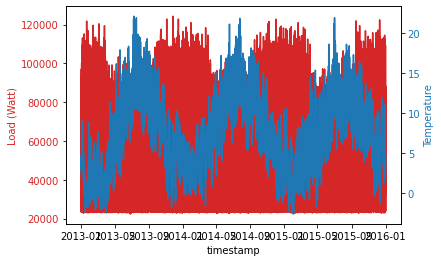

In [75]:
# Ensure timestamps are sorted
df_load = df_load.sort_values(by='timestamp')
df_weather = df_weather.sort_values(by='timestamp')

# Create a figure and a set of subplots
fig, ax1 = plt.subplots()
# Plot 'Load (Watt)' on y-axis and 'timestamp' on x-axis
color = 'tab:red'
ax1.set_xlabel('timestamp')
ax1.set_ylabel('Load (Watt)', color=color)
ax1.plot(df_load['timestamp'], df_load['Load (Watt)'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second y-axis sharing the same x-axis
ax2 = ax1.twinx()  

# Plot 'temperature' on second y-axis
color = 'tab:blue'
ax2.set_ylabel('Temperature', color=color)  
ax2.plot(df_weather['timestamp'], df_weather['temperature'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Show the plot
plt.show()

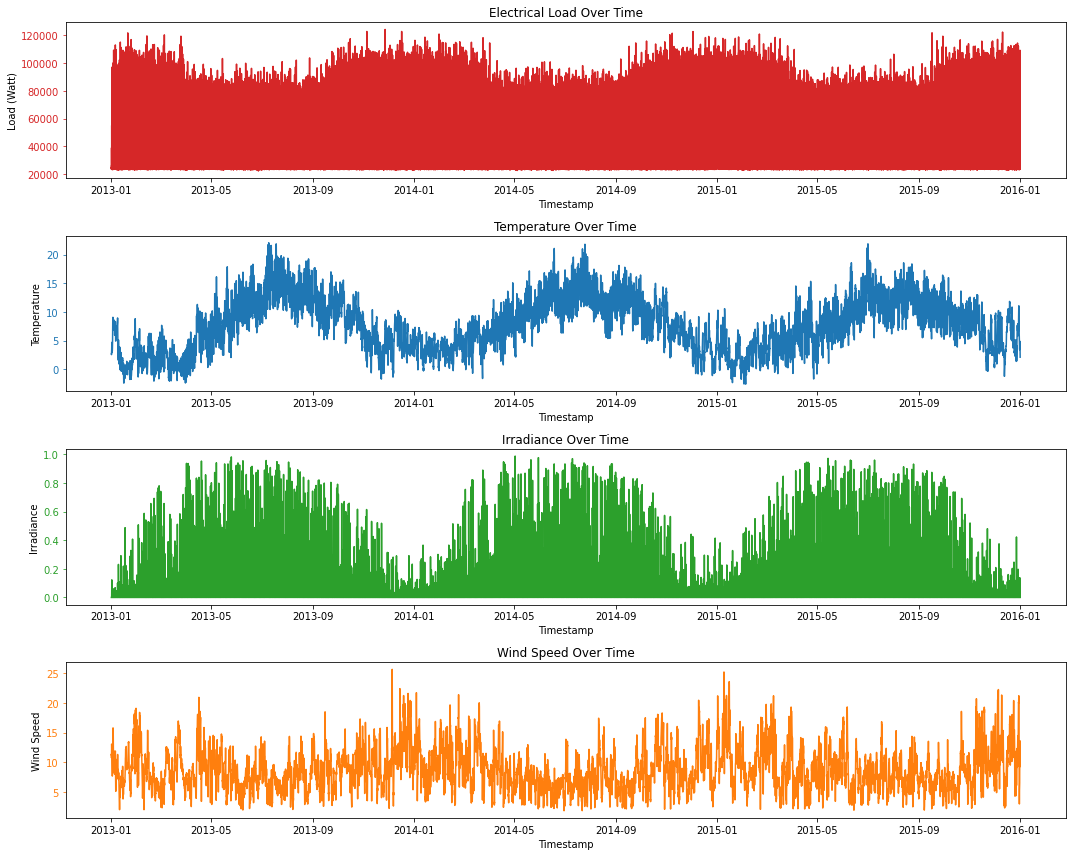

In [87]:
# Creating a figure for the plots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))

# Plotting 'Load (Watt)' from df_load
ax1.plot(df_load['timestamp'], df_load['Load (Watt)'], color='tab:red')
ax1.set_title('Electrical Load Over Time')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Load (Watt)')
ax1.tick_params(axis='y', colors='tab:red')

# Plotting 'temperature' from df_weather
ax2.plot(df_weather['timestamp'], df_weather['temperature'], color='tab:blue')
ax2.set_title('Temperature Over Time')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('Temperature')
ax2.tick_params(axis='y', colors='tab:blue')

# Plotting 'irradiance_total' from df_weather
ax3.plot(df_weather['timestamp'], df_weather['irradiance_total'], color='tab:green')
ax3.set_title('Irradiance Over Time')
ax3.set_xlabel('Timestamp')
ax3.set_ylabel('Irradiance')
ax3.tick_params(axis='y', colors='tab:green')

# Plot wind speed from df_weather
ax4.plot(df_weather['timestamp'], df_weather['wind_speed'], color='tab:orange')
ax4.set_title('Wind Speed Over Time')
ax4.set_xlabel('Timestamp')
ax4.set_ylabel('Wind Speed')
ax4.tick_params(axis='y', colors='tab:orange')


# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [91]:
# Plot moving averages of load, temperature, irradiance, and wind speed


# Print max value of total irradiance
print('Max irradiance: ', df_weather['irradiance_total'].max())
print(df_weather['irradiance_total'].mean())
print(df_weather['wind_speed'].mean())

area_house = 80 # in m^2
average_panel_size = 1.6 # in m^2
panel_efficiency = 0.2
solar_price_per_wp = 3 # in USD

Max irradiance:  0.989
0.1319505707762557
8.745095167427701


In [ ]:
# Calculate the total solar power that can be installed
total_solar_power = area_house * average_panel_size * panel_efficiency

# Irradiance in df_weather is given in 1kW/m^2
# Calculate the total solar power that would be produced 

In [93]:
def get_wind_power(df_weather, v_cut_in, v_cut_off, rated_power):
    


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed